<a href="https://colab.research.google.com/github/sudheerpunuri82/Facial-Expression-Recognition-in-Unconstrained-Environment/blob/main/Ensemble_AffectNet_Ha%26SaEmotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 8.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /root/.kaggle

In [ ]:
# !cp /content/kaggle.json  /root/.kaggle

In [ ]:
# !cp /content/kaggle.json /content/drive/MyDrive

In [ ]:
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle/

In [ ]:
!cp '/content/drive/MyDrive/kaggle.json' /root/.kaggle

In [ ]:
!kaggle datasets download -d noamsegal/affectnet-training-data

401 - Unauthorized


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt  # plot
import random


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.activations import gelu
import numpy as np

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# !unzip '/content/affectnet-training-data.zip' -d '/content/Affectnet/'

!unzip '/content/drive/MyDrive/affectnet.zip' -d '/content/Affectnet/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/Affectnet/sad/image0025659.jpg  
  inflating: /content/Affectnet/sad/image0025666.jpg  
  inflating: /content/Affectnet/sad/image0025673.jpg  
  inflating: /content/Affectnet/sad/image0025679.jpg  
  inflating: /content/Affectnet/sad/image0025681.jpg  
  inflating: /content/Affectnet/sad/image0025693.jpg  
  inflating: /content/Affectnet/sad/image0025694.jpg  
  inflating: /content/Affectnet/sad/image0025697.jpg  
  inflating: /content/Affectnet/sad/image0025715.jpg  
  inflating: /content/Affectnet/sad/image0025725.jpg  
  inflating: /content/Affectnet/sad/image0025726.jpg  
  inflating: /content/Affectnet/sad/image0025730.jpg  
  inflating: /content/Affectnet/sad/image0025736.jpg  
  inflating: /content/Affectnet/sad/image0025753.jpg  
  inflating: /content/Affectnet/sad/image0025760.jpg  
  inflating: /content/Affectnet/sad/image0025761.jpg  
  inflating: /content/Affectnet/sad/image0025769.jpg  
  inflating: /

In [ ]:
import os
def countFile(link):
    path = link
    num_files = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])

    print(f"Number of files in directory {link} is ", num_files)

In [ ]:
import cv2
import numpy as np
from keras.utils import to_categorical
import os
import pandas as pd

In [ ]:
countFile('/content/Affectnet/happy')
countFile('/content/Affectnet/sad')

Number of files in directory /content/Affectnet/happy is  5044
Number of files in directory /content/Affectnet/sad is  3091


In [ ]:
import os
import cv2
import numpy as np

INPUT_PATH = '/content/Affectnet'
EMOTIONS = ["happy", "sad"]  # Update with your 4 emotions
IMAGE_SIZE = (96, 96)
classes = ["HAPPY", "SAD"]


In [ ]:
def image_generator(input_path, emotions, image_size):
    for label, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            #img = cv2.resize(img, image_size)
            #img = img.astype('float32') / 255.0  # Normalize
            yield img, label

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [ ]:
X, y = load_images(INPUT_PATH, EMOTIONS, IMAGE_SIZE)
input_shape = X[0].shape
print(input_shape)

(96, 96, 3)


In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and test first (70% train, 30% test)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Split the remaining data into validation and test (50% validation, 50% test)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.50, random_state=42, stratify=y_test)

# Now you have X_train, y_train, X_val, y_val, X_test, and y_test with proper shapes

In [ ]:
y_train = to_categorical(y_train,dtype = 'int32')
y_val = to_categorical(y_val,dtype = 'int32')
y_test = to_categorical(y_test,dtype = 'int32')

In [ ]:
# Print the shapes to verify
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (5694, 96, 96, 3) - y_train shape: (5694, 2)
x_val shape: (1220, 96, 96, 3) - y_val shape: (1220, 2)
x_test shape: (1221, 96, 96, 3) - y_test shape: (1221, 2)


*display a sample image*

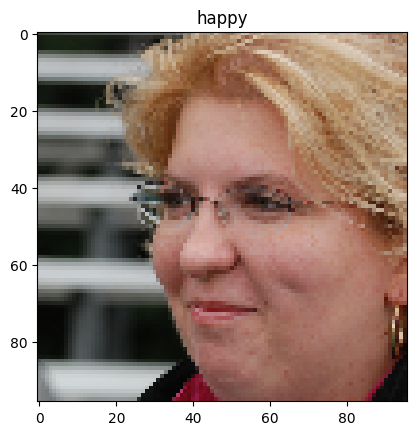

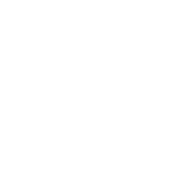

In [ ]:
idx = np.random.randint(len(X))

# display the image and its corresponding label from arrays
plt.imshow(X[idx])
plt.title(EMOTIONS[np.argmax(y[idx])])
# Create a smaller figure by specifying figsize
plt.figure(figsize=(2, 2))  # You can adjust the width and height as needed

plt.axis('off')  # remove the grid
plt.show()

*Hyper Parameters*

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# transformer_units = [
#     projection_dim * 2,
#     projection_dim,
# ]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
drop_out = 0.1
num_class = 2

*Data Augmentation*

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def run_experiment(model,name):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            tfa.metrics.F1Score(num_classes=2)
        ],
    )

    checkpoint_filepath = f"/content/tmp/{name}/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=50,
        validation_data = (x_val,y_val),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, f1_score_res = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print("f1_score: ", f1_score_res)

    return history,model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
def confusionmatrix_generation(model_name, name):

  # Make predictions on the test data
  y_pred = model_name.predict(x_test)

  # Convert one-hot encoded labels to class labels
  y_true_labels = np.argmax(y_test, axis=1)
  y_pred_labels = np.argmax(y_pred, axis=1)

  # Calculate the confusion matrix
  confusion = confusion_matrix(y_true_labels, y_pred_labels)

  # Plot the confusion matrix
  plt.figure(figsize=(6, 4))
  sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(name)
  plt.show()


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
def resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    # output has shape of (None, 2)
    output = layers.Dense(num_class, activation="softmax")(x)
    model = keras.Model(inputs=base_model.input, outputs=output)
    return model

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models

def vgg19_model():
    base_model = VGG19(weights='imagenet', include_top=False)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(units=2, activation='softmax')(x)  # Change units to the number of classes
    model = models.Model(inputs=base_model.input, outputs=output)
    return model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, models

def inception_model():
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(units=2, activation='softmax')(x)  # Fix this line
    model = models.Model(inputs=base_model.input, outputs=output)
    return model

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import layers, models

def mobilenetv2_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    num_classes = 2  # Set the number of output classes as needed
    output = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=output)

    return model

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

def efficientnet_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(units=2, activation='softmax')(x)  # Change units to the number of classes
    model = models.Model(inputs=base_model.input, outputs=output)
    return model

In [ ]:
vgg19 = vgg19_model()
history_vgg19, vgg19_classifier = run_experiment(vgg19, "VGG19 Model")
confusionmatrix_generation(vgg19_classifier, "VGG19 Model")

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/50
23/23 [==============================] - 44s 692ms/step - loss: 0.1592 - accuracy: 0.9345 - f1_score: 0.9309 - val_loss: 0.4579 - val_accuracy: 0.8418 - val_f1_score: 0.8121
Epoch 2/50
23/23 [==============================] - 10s 420ms/step - loss: 0.0241 - accuracy: 0.9917 - f1_score: 0.9913 - val_loss: 0.1529 - val_accuracy: 0.9361 - val_f1_score: 0.9297
Epoch 3/50
23/23 [==============================] - 10s 421ms/step - loss: 0.0057 - accuracy: 0.9981 - f1_score: 0.9979 - val_loss: 0.1084 - val_accuracy: 0.9525 - val_f1_score: 0.9482
Epoch 4/50
23/23 [==============================] - 9s 389ms/step - loss: 0.0019 - accuracy: 0.9993 - f1_score: 0.9993 - val_loss: 0.1383 - val_accuracy: 0.9500 - val_f1_score: 0.9454
Epoch 5/50
23/23 [==============================] - 10s 433ms/step - loss: 0.0029 - accuracy: 0.9991 - f1_score: 0.9991 - val_loss: 0.0207 - val_accuracy: 0.9926 - val_f1_score: 0.9922
Epoch 6/50


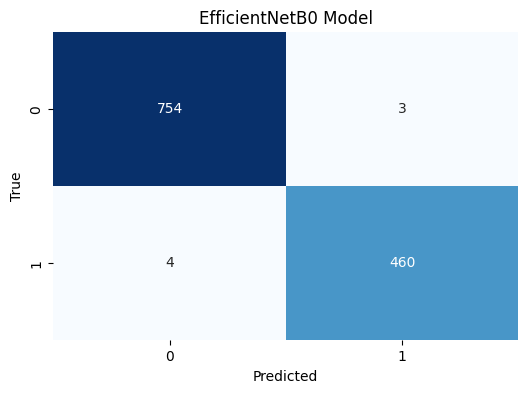

In [ ]:
efficientnet = efficientnet_model()
history_efficientnet, e_classifier = run_experiment(efficientnet, "EfficientNetBo Model")
confusionmatrix_generation(e_classifier, "EfficientNetB0 Model")

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/50
23/23 [==============================] - 31s 662ms/step - loss: 0.3460 - accuracy: 0.8606 - f1_score: 0.8485 - val_loss: 68.9755 - val_accuracy: 0.6205 - val_f1_score: 0.3829
Epoch 2/50
23/23 [==============================] - 8s 362ms/step - loss: 0.0385 - accuracy: 0.9884 - f1_score: 0.9877 - val_loss: 3.8664 - val_accuracy: 0.6254 - val_f1_score: 0.3969
Epoch 3/50
23/23 [==============================] - 9s 378ms/step - loss: 0.0068 - accuracy: 0.9977 - f1_score: 0.9976 - val_loss: 2.3321 - val_accuracy: 0.6541 - val_f1_score: 0.6538
Epoch 4/50
23/23 [==============================] - 8s 348ms/step - loss: 0.0038 - accuracy: 0.9984 - f1_score: 0.9983 - val_loss: 0.2172 - val_accuracy: 0.9443 - val_f1_score: 0.9396
Epoch 5/50
23/23 [==============================] - 7s 297ms/step - loss: 0.0051 - accuracy: 0.9989 - f1_score: 0.9989 - val_loss: 0.9965 - val_accuracy: 0.8352 - val_f1_score: 0.8334
Epoch 6/50
23

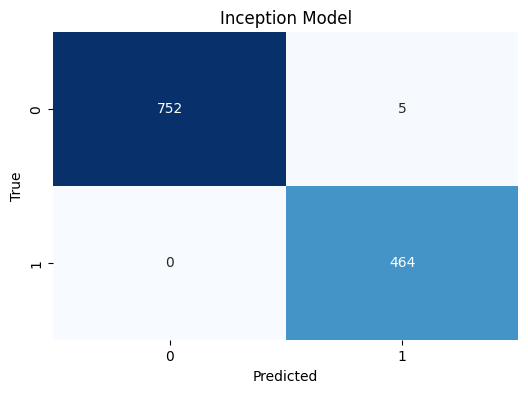

In [ ]:
inception = inception_model()
history_inception, i_classifier = run_experiment(inception, "Inception V2")
confusionmatrix_generation(i_classifier, "Inception Model")

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/50
23/23 [==============================] - 17s 425ms/step - loss: 0.1887 - accuracy: 0.9312 - f1_score: 0.9269 - val_loss: 4.9543 - val_accuracy: 0.7910 - val_f1_score: 0.7668
Epoch 2/50
23/23 [==============================] - 5s 238ms/step - loss: 0.0188 - accuracy: 0.9961 - f1_score: 0.9959 - val_loss: 10.6546 - val_accuracy: 0.7238 - val_f1_score: 0.6246
Epoch 3/50
23/23 [==============================] - 5s 238ms/step - loss: 0.0056 - accuracy: 0.9979 - f1_score: 0.9978 - val_loss: 8.2053 - val_accuracy: 0.7525 - val_f1_score: 0.6749
Epoch 4/50
23/23 [==============================] - 5s 237ms/step - loss: 0.0048 - accuracy: 0.9977 - f1_score: 0.9976 - val_loss: 6.2758 - val_accuracy: 0.7762 - val_f1_score: 0.7157
Epoch 5/50
23/23 [==============================] - 6s 268ms/step - loss: 0.0048 - accuracy: 0.9982 - f1_score: 0.9981 - val_loss: 4.3305 - val_accuracy: 0.8287 - val_f1_score: 0.7936
Epoch 6/50
23/2

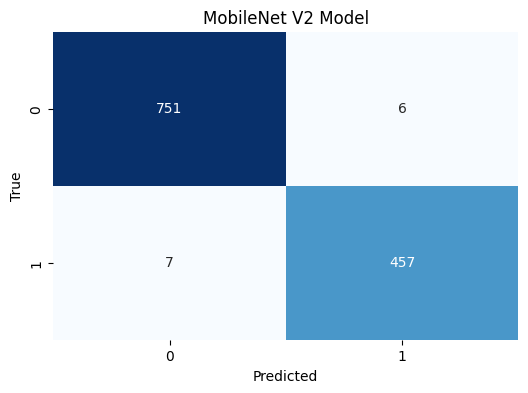

In [ ]:
mobilenetv2 = mobilenetv2_model()
# mobilenetv2_classifier.summary()
history, m_classifier = run_experiment(mobilenetv2, "Mobilenetv2")
confusionmatrix_generation(m_classifier, "MobileNet V2 Model")

In [ ]:
e_classifier.save('/content/drive/MyDrive/e_classifier.h5')
m_classifier.save('/content/drive/MyDrive/m_classifier.h5')
i_classifier.save('/content/drive/MyDrive/i_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


*Image Plot and Prediction*

In [ ]:
import matplotlib.pyplot as plt

def predict_and_display_image(model, model_name, x_test, y_test, image_index):
    """
    Predict the class of an image and display it with ground truth.

    Parameters:
    - model: The trained model for prediction.
    - model_name: Name of the model for display.
    - x_test: Test dataset containing images.
    - y_test: Ground truth labels corresponding to the test dataset.
    - image_index: Index of the image in the test dataset (x_test).

    Returns:
    - None (displays the image with annotations).
    """
    # Select the image and label based on the provided index
    image = x_test[image_index]
    true_label = y_test[image_index]

    # Define class labels
    class_labels = ['Happy', 'Sad']

    # Get the ground truth label for the image
    ground_truth = "Ground Truth: " + class_labels[np.argmax(true_label)]

    # Predict the class of the image using the model
    prediction = model.predict(np.expand_dims(image, axis=0))
    predicted_class = "Predicted: " + class_labels[np.argmax(prediction)]

    # Display the image with annotations
    plt.figure(figsize=(4, 2))
    plt.imshow(image)
    plt.title(model_name)
    plt.xlabel(predicted_class)
    plt.ylabel(ground_truth)
    plt.show()

# Example usage:
# Replace 'model', 'model_name', 'x_test', 'y_test', and 'image_index' with your actual values
# predict_and_display_image(model, "Model Name", x_test, y_test, image_index)


1/1 [==============================] - 0s 30ms/step


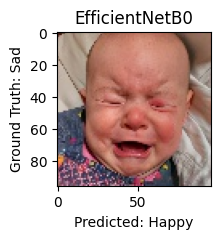

1/1 [==============================] - 0s 28ms/step


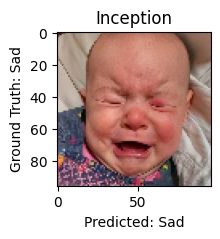

1/1 [==============================] - 0s 23ms/step


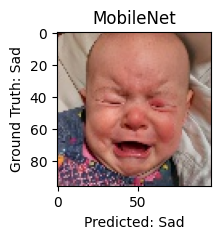

1/1 [==============================] - 0s 25ms/step


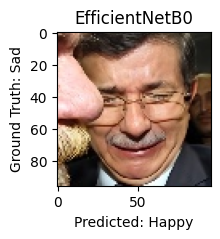

1/1 [==============================] - 0s 28ms/step


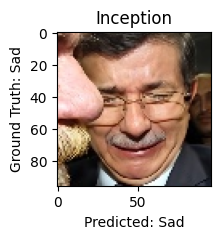

1/1 [==============================] - 0s 27ms/step


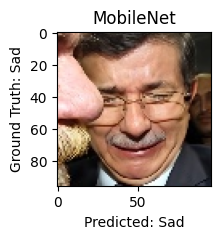

1/1 [==============================] - 0s 26ms/step


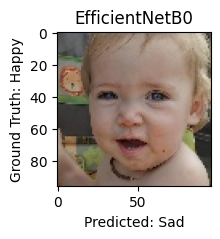

1/1 [==============================] - 0s 27ms/step


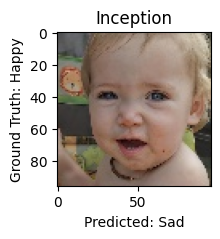

1/1 [==============================] - 0s 25ms/step


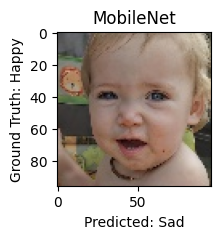

1/1 [==============================] - 0s 26ms/step


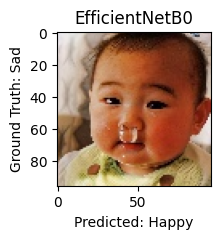

1/1 [==============================] - 0s 26ms/step


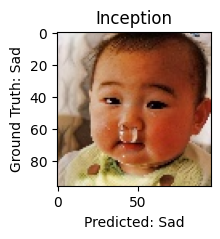

1/1 [==============================] - 0s 27ms/step


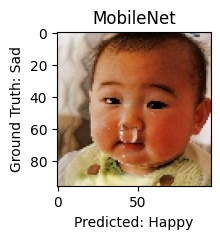

1/1 [==============================] - 0s 27ms/step


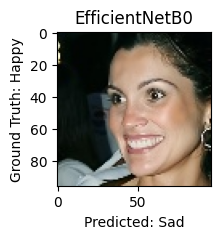

1/1 [==============================] - 0s 26ms/step


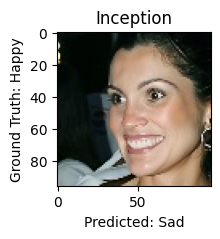

1/1 [==============================] - 0s 23ms/step


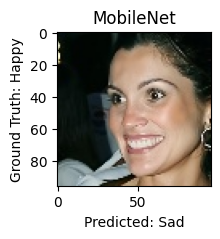

1/1 [==============================] - 0s 25ms/step


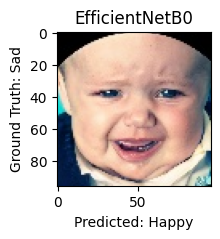

1/1 [==============================] - 0s 28ms/step


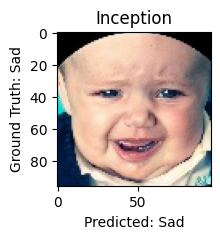

1/1 [==============================] - 0s 24ms/step


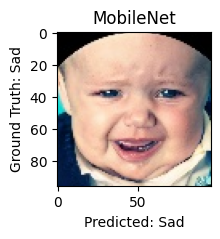

1/1 [==============================] - 0s 25ms/step


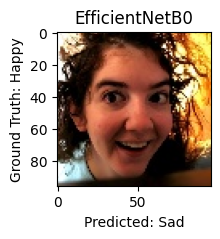

1/1 [==============================] - 0s 25ms/step


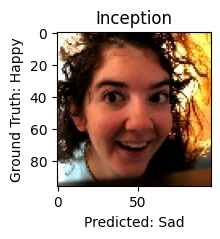

1/1 [==============================] - 0s 44ms/step


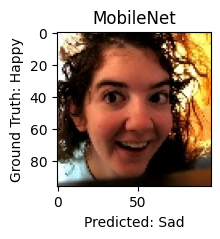

1/1 [==============================] - 0s 56ms/step


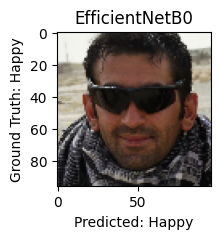

1/1 [==============================] - 0s 43ms/step


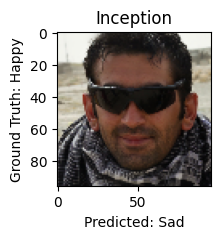

1/1 [==============================] - 0s 44ms/step


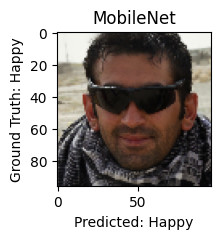

1/1 [==============================] - 0s 43ms/step


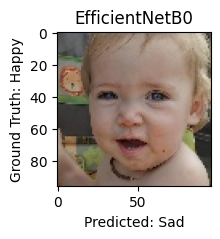

1/1 [==============================] - 0s 45ms/step


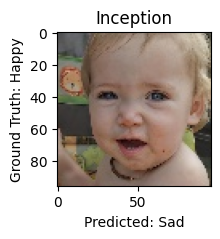

1/1 [==============================] - 0s 34ms/step


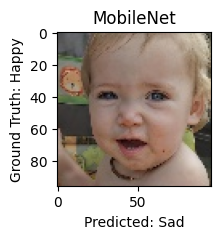

1/1 [==============================] - 0s 46ms/step


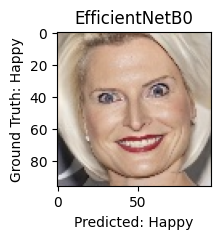

1/1 [==============================] - 0s 40ms/step


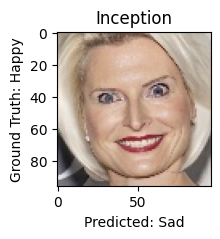

1/1 [==============================] - 0s 61ms/step


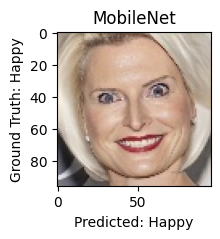

1/1 [==============================] - 0s 42ms/step


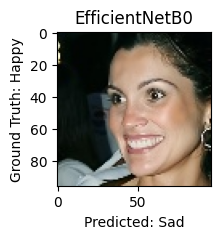

1/1 [==============================] - 0s 44ms/step


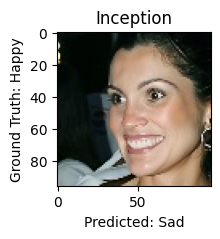

1/1 [==============================] - 0s 23ms/step


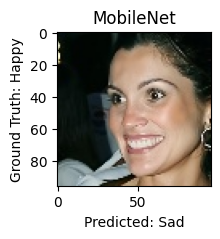

1/1 [==============================] - 0s 27ms/step


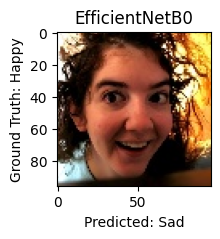

1/1 [==============================] - 0s 26ms/step


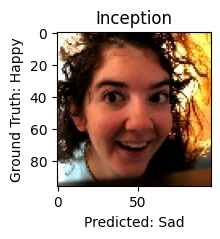

1/1 [==============================] - 0s 24ms/step


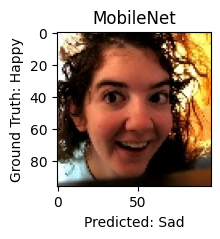

1/1 [==============================] - 0s 25ms/step


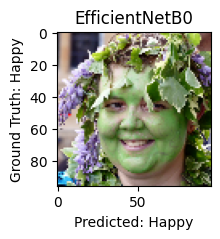

1/1 [==============================] - 0s 26ms/step


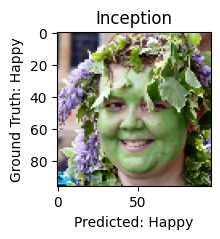

1/1 [==============================] - 0s 24ms/step


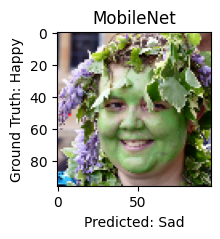

In [ ]:
for i in [138, 207, 437,579, 879, 882, 1049, 390, 437, 604, 879, 1049, 106]:
  predict_and_display_image(e_classifier, "EfficientNetB0", x_test, y_test, i)
  predict_and_display_image(i_classifier, "Inception", x_test, y_test, i)
  predict_and_display_image(m_classifier, "MobileNet", x_test, y_test, i)

*Wrongly predicted images*

In [ ]:
def find_wrongly_predicted_indices(model, x_test, y_test):
    """
    Find the indices of wrongly predicted images.

    Parameters:
    - model: The trained model for prediction.
    - x_test: Test dataset containing images.
    - y_test: Ground truth labels corresponding to the test dataset.

    Returns:
    - List of indices for wrongly predicted images.
    """
    # Get model predictions for the entire test dataset
    predictions = model.predict(x_test)

    # Convert predictions to class labels (assuming a 2-class problem)
    predicted_labels = np.argmax(predictions, axis=1)

    # Compare predicted labels with ground truth labels
    wrongly_predicted_indices = np.where(predicted_labels != np.argmax(y_test, axis=1))[0]

    return wrongly_predicted_indices

# Example usage:
# Replace 'model', 'x_test', and 'y_test' with your actual values
# wrongly_predicted_indices = find_wrongly_predicted_indices(model, x_test, y_test)
# print("Wrongly Predicted Indices:", wrongly_predicted_indices)


In [ ]:
print(find_wrongly_predicted_indices(e_classifier, x_test, y_test))
print(find_wrongly_predicted_indices(i_classifier, x_test, y_test))
print(find_wrongly_predicted_indices(m_classifier, x_test, y_test))

39/39 [==============================] - 1s 16ms/step
[ 138  207  437  579  879  882 1049]
39/39 [==============================] - 1s 14ms/step
[ 390  437  604  879 1049]
39/39 [==============================] - 0s 9ms/step
[ 106  151  386  437  462  469  567  579  646  879  946 1049 1181]


In [ ]:
x_test.shape

(1221, 96, 96, 3)

1/1 [==============================] - 0s 49ms/step


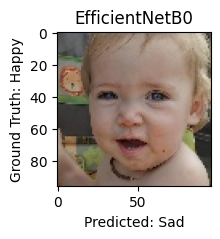

1/1 [==============================] - 0s 44ms/step


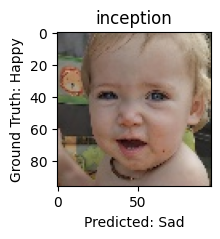

1/1 [==============================] - 0s 25ms/step


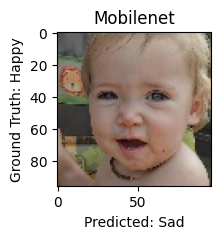

In [ ]:
predict_and_display_image(e_classifier, "EfficientNetB0", x_test, y_test,437)
predict_and_display_image(i_classifier, "inception", x_test, y_test,437)
predict_and_display_image(m_classifier, "Mobilenet", x_test, y_test,437)

1/1 [==============================] - 0s 27ms/step


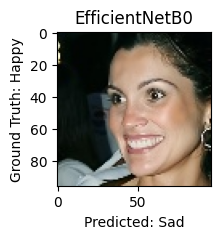

1/1 [==============================] - 0s 26ms/step


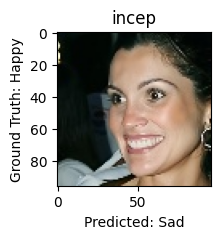

1/1 [==============================] - 0s 21ms/step


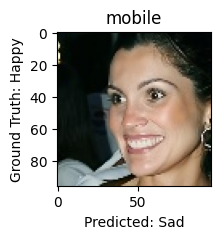

In [ ]:
predict_and_display_image(e_classifier, "EfficientNetB0", x_test, y_test,879)
predict_and_display_image(i_classifier, "incep", x_test, y_test,879)
predict_and_display_image(m_classifier, "mobile", x_test, y_test,879)


1/1 [==============================] - 0s 92ms/step


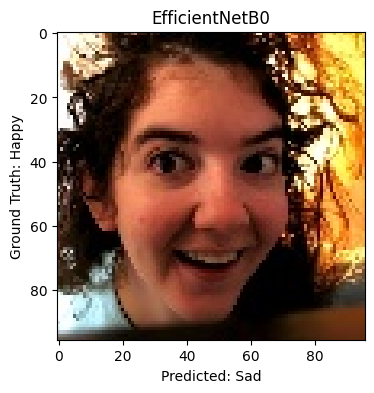

In [ ]:
predict_and_display_image(e_classifier, "EfficientNetB0", x_test, y_test, 1049)

In [ ]:
import numpy as np

def get_image_confidence_score(x_test, model, image_index):
    """
    Get the confidence score for a specific image in the test dataset.

    Parameters:
    - x_test: Test dataset containing images.
    - model: The trained model used for predictions.
    - image_index: Index of the image in the test dataset (x_test).

    Returns:
    - Confidence score for the specified image.
    """
    # Select the image based on the provided index
    image = x_test[image_index]

    # Get model prediction for the selected image
    prediction = model.predict(np.expand_dims(image, axis=0))

    # Assuming prediction is a 2-class output, you can access the confidence scores as follows:
    confidence_scores = prediction[0]  # Replace with your model's output structure
    # confidence_scores = np.round(prediction[0], 4)  # Round to 4 digits after the decimal point
    return confidence_scores

# Example usage:
# Replace 'x_test', 'model', and 'image_index' with your actual test dataset, model, and image index
# confidence_scores = get_image_confidence_score(x_test, model, image_index)
# print("Confidence Scores:", confidence_scores)
import pandas as pd
import numpy as np

def gaussian_function(x):
    return np.exp(-((x - 1)**2) / 2)
def tanh_function(x):
    return np.tanh(((x - 1)**2) / 2)


def fused_rank(x):

  r1 = 1-gaussian_function(x)
  r2 = 1-tanh_function(x)

  # Calculate Fused Score
  fused_rank = r1 * r2

  return r1, r2, fused_rank

In [ ]:
index = 879
cs_m = get_image_confidence_score(x_test, m_classifier, index)
print(cs_m)
cs_e = get_image_confidence_score(x_test, e_classifier, index)
print(cs_e)
cs_i = get_image_confidence_score(x_test, i_classifier, index)
print(cs_i)

1/1 [==============================] - 0s 117ms/step
[6.483887e-22 1.000000e+00]
1/1 [==============================] - 0s 79ms/step
[1.1376265e-04 9.9988627e-01]
1/1 [==============================] - 0s 83ms/step
[0.00184155 0.9981585 ]


In [ ]:
# Calculate Rank1, Rank2, and Fused Score for each vector
rank1_m, rank2_m, fused_m = fused_rank(cs_m)
rank1_i, rank2_i, fused_i = fused_rank(cs_i)
rank1_e, rank2_e, fused_e = fused_rank(cs_e)

# Create a DataFrame to organize the results
data = {
    'Class': ['HAPPY', 'SAD'],
    'cs_m Rank1': [rank1_m[0], rank1_m[1]],
    'cs_m Rank2': [rank2_m[0], rank2_m[1]],
    'cs_m Fused Rank': [fused_m[0], fused_m[1]],
    'cs_i Rank1': [rank1_i[0], rank1_i[1]],
    'cs_i Rank2': [rank2_i[0], rank2_i[1]],
    'cs_i Fused Rank': [fused_i[0], fused_i[1]],
    'cs_e Rank1': [rank1_e[0], rank1_e[1]],
    'cs_e Rank2': [rank2_e[0], rank2_e[1]],
    'cs_e Fused Rank': [fused_e[0], fused_e[1]]
}

# Create a Pandas DataFrame
results_df = pd.DataFrame(data)
# Display the DataFrame
print(results_df)

   Class  cs_m Rank1  cs_m Rank2  cs_m Fused Rank  cs_i Rank1  cs_i Rank2  \
0  HAPPY    0.393469    0.537883          0.21164    0.392352    0.539331   
1    SAD    0.000000    1.000000          0.00000    0.000002    0.999998   

   cs_i Fused Rank  cs_e Rank1  cs_e Rank2  cs_e Fused Rank  
0         0.211608      0.3934    0.537972         0.211638  
1         0.000002      0.0000    1.000000         0.000000  


In [ ]:
import pandas as pd
import numpy as np

# Create the previous table (replace this with your actual data)
data_previous = {
    'Class': ['HAPPY', 'SAD'],
    'cs_m Rank1': [rank1_m[0], rank1_m[1]],
    'cs_m Rank2': [rank2_m[0], rank2_m[1]],
    'cs_m Fused Score': [fused_m[0], fused_m[1]],
    'cs_i Rank1': [rank1_i[0], rank1_i[1]],
    'cs_i Rank2': [rank2_i[0], rank2_i[1]],
    'cs_i Fused Score': [fused_i[0], fused_i[1]],
    'cs_e Rank1': [rank1_e[0], rank1_e[1]],
    'cs_e Rank2': [rank2_e[0], rank2_e[1]],
    'cs_e Fused Score': [fused_e[0], fused_e[1]]
}

previous_table = pd.DataFrame(data_previous)

# Extract values for fused_m, fused_i, and fused_e from the previous table
fused_m = previous_table['cs_m Fused Score'].values
fused_i = previous_table['cs_i Fused Score'].values
fused_e = previous_table['cs_e Fused Score'].values

# Calculate the product of Fused Scores for each class (Class 1 and Class 2)
product_fused_score_class1 = fused_m[0] * fused_i[0] * fused_e[0]
product_fused_score_class2 = fused_m[1] * fused_i[1] * fused_e[1]

# Create a Pandas DataFrame to organize the results
data = {
    'Class': ['HAPPY', 'SAD'],
    'MobileNetv2': [fused_m[0], fused_m[1]],
    'EfficientNetB0': [fused_e[0], fused_e[1]],
    'InceptionV': [fused_i[0], fused_i[1]],
    'Fused Scores': [product_fused_score_class1, product_fused_score_class2]
}

# Create a Pandas DataFrame
results_df = pd.DataFrame(data)

# Display the DataFrame
print(results_df)

min_fused_score = results_df['Fused Scores'].min()
predicted_class = results_df.loc[results_df['Fused Scores'] == min_fused_score, 'Class'].values[0]

# Highlight the predicted class in the DataFrame
results_df['Class'] = results_df['Class'].apply(lambda x: f"**{x}**" if x == predicted_class else x)

# Print the DataFrame with the predicted class highlighted
print(results_df.to_markdown(index=False))

# Print the predicted class
print(f"Predicted Class: {predicted_class}")

   Class  MobileNetv2  EfficientNetB0  InceptionV  Fused Scores
0  HAPPY      0.21164        0.211638    0.211608      0.009478
1    SAD      0.00000        0.000000    0.000002      0.000000
| Class   |   MobileNetv2 |   EfficientNetB0 |   InceptionV |   Fused Scores |
|:--------|--------------:|-----------------:|-------------:|---------------:|
| HAPPY   |       0.21164 |         0.211638 |  0.211608    |     0.00947818 |
| **SAD** |       0       |         0        |  1.72853e-06 |     0          |
Predicted Class: SAD
